---

#  mplfinance Date iLoc Transform

---

In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import pandas as pd

In [3]:
import mplfinance as mpf
mpf.__version__

'0.12.7a17'

In [4]:
import glob

In [5]:
df = pd.read_csv('../data/SP500_NOV2019_Hist.csv',index_col=0,parse_dates=True)
df = pd.read_csv('../data/yahoofinance-SPY-20200901-20210113.csv',index_col=0,parse_dates=True)

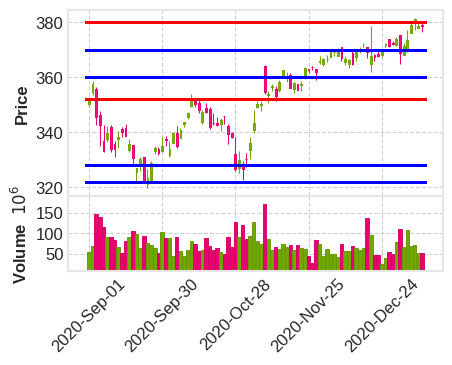

In [6]:
hlines = [322,328,352,360,370,380]
colors = ['b','b','r','b','b','r']
mpf.plot(df,type='candle',volume=True,style='binance',hlines=dict(hlines=hlines,colors=colors),figscale=.65)

### Uses for DateIlocTransform

#### All uses are for `show_nontrading=False` only:

- `.to_date()` &nbsp; location *to* date: &nbsp; for tick label formatting.
- `.to_iloc()` &nbsp; date *to* location: &nbsp; for `xticks` placement.
- `.to_iloc()` &nbsp; date *to* location: &nbsp; for `xlim` placement.
- `.to_iloc()` &nbsp; date *to* location: &nbsp; for `lines` placement.

---

- It seems to me that  
  - **interpolation** may be better using the actual datetime series (rather than the linear formula), whereas 
  - **extrapolation** *will require* the linear formula.
    - Or for "known" cases may be able to use **date calculations**, for example:
      - quartile(0.65) == quartile(0.50) == quartile(0.35) == "known" frequency.
      - intraday with consistent trading hours in data
      - daily with weekends missing (maybe someday allow users to supply holidays)
      - weekly, monthly, yearly, etc. are simple?
  - need to run some tests to see which, if either, is better.
- Keep in mind, while testing, that `xlim` values will affect `xticks` placement.


In [7]:
class TimeSeriesFrequency:

    def __init__(self,dfreq='B',ifreq='H',weekmask=None,open_time='09:30',close_time='16:00'):
        self._dfreq  = dfreq
        self._ifreq  = ifreq
        self._wmask  = weekmask
        self._topen  = pd.Timestamp(open_time)
        self._tclose = pd.Timestamp(close_time)

    def __repr__(self):
        s  = self.__class__.__name__
        s += "(d='"+str(self._dfreq)+"'"
        s += ", i='"+str(self._ifreq)+"'"
        s += ", w='"+str(self._wmask)+"'"
        s += ", o='"+str(self._topen.strftime('%H:%M:%S'))+"'"
        s += ", c='"+str(self._tclose.strftime('%H:%M:%S'))+"'"
        s += ")"
        return s
    

In [8]:
td = pd.Timedelta(days=0, hours=0, minutes=15, seconds=0)
#(td.seconds % 60)
td

d1 = pd.date_range('5/25/2021','5/27/2021',freq=td)
pd.date_range('5/25/2021','5/27/2021',freq='4S')

n = 4
str(n)+'H'

Timedelta('0 days 00:15:00')

DatetimeIndex(['2021-05-25 00:00:00', '2021-05-25 00:00:04',
               '2021-05-25 00:00:08', '2021-05-25 00:00:12',
               '2021-05-25 00:00:16', '2021-05-25 00:00:20',
               '2021-05-25 00:00:24', '2021-05-25 00:00:28',
               '2021-05-25 00:00:32', '2021-05-25 00:00:36',
               ...
               '2021-05-26 23:59:24', '2021-05-26 23:59:28',
               '2021-05-26 23:59:32', '2021-05-26 23:59:36',
               '2021-05-26 23:59:40', '2021-05-26 23:59:44',
               '2021-05-26 23:59:48', '2021-05-26 23:59:52',
               '2021-05-26 23:59:56', '2021-05-27 00:00:00'],
              dtype='datetime64[ns]', length=43201, freq='4S')

'4H'

In [9]:
# td = pd.Timedelta(days=0, hours=0, minutes=3, seconds=12.5001)
# td
# td.seconds
# td.microseconds/1000
# hours   = round(td.seconds/(60*60),0)
# hours
# minutes = round(td.seconds%(60*60)/60,0)
# minutes
# seconds = round(td.seconds%60.,0)
# seconds
# if td.microseconds/1000 >= 500:
#     seconds += 1.
# seconds

In [10]:
def timedelta_to_freqabbr(td):
    if not isinstance(td,pd.Timedelta): return None
    hours   = int(round(td.seconds/(60*60)))
    minutes = int(round(td.seconds%(60*60)/60))
    seconds = int(round(td.seconds%60))
    if td.microseconds/1000 >= 500:
        seconds += 1.
    # If only one of hours, minutes, or seconds is
    # non-zero, then we can use an abbreviation.
    if minutes == seconds == 0:
        freq = str(hours)+'H'
    elif hours == seconds == 0:
        freq = str(minutes)+'T'
    elif hours == minutes == 0:
        freq = str(seconds)+'S'
    else:
        freq = None
    return freq

In [11]:
def _infer_weekmask(ix):
    weekdaydf = pd.DataFrame(dict(date=ix,dayofweek=[d.dayofweek for d in ix]))
    weekdays  = weekdaydf.groupby('dayofweek').count()
    c = weekdays.columns[0]
    cutoff = 0.25 * weekdays[c].max()
    days = weekdays[ weekdays[c] > cutoff].index.values
    #print('days=',days)
    weekmask = [day in days for day in range(7)]
    print('weekmask=',weekmask)
    return weekmask

In [12]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-01,350.209991,352.709991,349.239990,352.600006,349.703522,54999300
2020-09-02,354.670013,358.750000,353.429993,357.700012,354.761627,69540000
2020-09-03,355.869995,356.380005,342.589996,345.390015,342.552765,148011100


In [13]:
_infer_weekmask(df.index)

weekmask= [True, True, True, True, True, False, False]


[True, True, True, True, True, False, False]

In [14]:
bday_Israel = pd.offsets.CustomBusinessDay(weekmask='Sun Mon Tue Wed Thu')
drI = pd.date_range(start='1/1/2001',periods=30,freq=bday_Israel)
drI

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04',
               '2001-01-07', '2001-01-08', '2001-01-09', '2001-01-10',
               '2001-01-11', '2001-01-14', '2001-01-15', '2001-01-16',
               '2001-01-17', '2001-01-18', '2001-01-21', '2001-01-22',
               '2001-01-23', '2001-01-24', '2001-01-25', '2001-01-28',
               '2001-01-29', '2001-01-30', '2001-01-31', '2001-02-01',
               '2001-02-04', '2001-02-05', '2001-02-06', '2001-02-07',
               '2001-02-08', '2001-02-11'],
              dtype='datetime64[ns]', freq='C')

In [15]:
_infer_weekmask(drI)

weekmask= [True, True, True, True, False, False, True]


[True, True, True, True, False, False, True]

In [26]:
def infer_frequency(data,trace=False):
    '''
    Infer the frequency of a pandas.DatetimeIndex
    even if that DatetimeIndex contains some gaps.
    
    Args:
        data:  DataFrame with a DatetimeIndex, or
               Series with a DatetimeIndex, or
               DatetimeIndex

    Returns:
        freq:  Inferred frequency of type `class TimeSeriesFrequency`
    '''
    if isinstance(data,(pd.core.frame.DataFrame,pd.core.frame.DataFrame)):
        if not isinstance(data.index,pd.core.indexes.datetimes.DatetimeIndex):
            raise TypeError('DataFrame or Series must have DatetimeIndex to infer frequency')
        dts = data.index.to_series()
    elif isinstance(data,pd.core.indexes.datetimes.DatetimeIndex):
        dts = data.to_series()
    else:
        raise TypeError('Input must be DataFrame, Series, or DatetimeIndex')
        
    # At this point `dts` is a datetime series
    
    if not dts.is_monotonic: dts = dts[::-1]
    if not dts.is_monotonic: raise ValueError('data is not monotonic!')
    diff = dts.diff(1)
    vc = diff.value_counts()
    basefreq = vc.idxmax()
    ifreq = None
    if basefreq.days < 1:
        abbr  = timedelta_to_freqabbr(basefreq)
        ifreq = basefreq if abbr is None else abbr
        dfreq = 'B'
        print(data.iloc[[0,1,2,-3,-2,-1]])
    elif basefreq.days == 1:
        dfreq = 'B'
        # infer weekmask:
        mask = _infer_weekmask(data.index)
    elif basefreq.days >= 6 and basefreq.days <= 8:
        dfreq = 'W'
    elif basefreq.days >= 29 and basefreq.days <= 31:
        dfreq = 'M'
    elif basefreq.days >=(3*29) and basefreq.days <= (3*31):
        dfreq = 'Q'
    elif basefreq.days >=(12*29) and basefreq.days <= (12*31):
        dfreq = 'Y'
    else:
        dfreq = None
    if trace:
        print('\nvc(value counts)=')
        print(vc)
        print('dfreq =',dfreq,'\n')
    return TimeSeriesFrequency(ifreq=ifreq,dfreq=dfreq)
    #type(diff.value_counts().index[0])
    #td = diff.value_counts().keys()[0]
    #td.days,td.seconds,td.microseconds,td.nanoseconds
    # TODO: Here we could do some pattern matching for gaps within the frequency

In [27]:
filelist = glob.glob('../data/*.csv')
for fn in filelist:
    df = pd.read_csv(fn,index_col=0,parse_dates=True)
    f = infer_frequency(df)
    print(f,fn)

weekmask= [True, True, True, True, True, False, False]
TimeSeriesFrequency(d='B', i='None', w='None', o='09:30:00', c='16:00:00') ../data/yahoofinance-GOOG-20040819-20180120.csv
weekmask= [True, True, True, True, True, False, False]
TimeSeriesFrequency(d='B', i='None', w='None', o='09:30:00', c='16:00:00') ../data/SPY_20110701_20120630_Bollinger.csv
                        Open    Close     High      Low  Volume
Date                                                           
2019-11-05 09:30:00  3080.80  3080.49  3081.47  3080.30       0
2019-11-05 09:31:00  3080.33  3079.36  3080.33  3079.15       0
2019-11-05 09:32:00  3079.43  3079.68  3080.46  3079.43       0
2019-11-08 15:57:00  3090.73  3090.70  3091.02  3090.52       0
2019-11-08 15:58:00  3090.73  3091.04  3091.13  3090.58       0
2019-11-08 15:59:00  3091.16  3092.91  3092.91  3090.96       0
TimeSeriesFrequency(d='B', i='1T', w='None', o='09:30:00', c='16:00:00') ../data/SP500_NOV2019_IDay.csv
weekmask= [True, True, True, Tru

In [18]:
fn ='../data/yahoofinance-INTC-19950101-20040412.csv'
fn='../data/gbpusd_yf20210401-0407.csv'
#fn='../data/SP500_20191106_IDayBollinger.csv'
#fn = '../data/jpyusd_barchartdotcom.csv'
df = pd.read_csv(fn,index_col=0,parse_dates=True)
infer_frequency(df[::-1],trace=True)
df

                         Open      High       Low     Close  Adj Close  Volume
Datetime                                                                      
2021-04-06 23:30:00  1.382457  1.382667  1.381941  1.382323   1.382323       0
2021-04-06 23:00:00  1.382457  1.382782  1.382094  1.382495   1.382495       0
2021-04-06 22:30:00  1.382189  1.382533  1.381769  1.382418   1.382418       0
2021-04-01 06:00:00  1.376671  1.376785  1.375516  1.376008   1.376008       0
2021-04-01 05:30:00  1.377809  1.378094  1.376122  1.376747   1.376747       0
2021-04-01 05:00:00  1.378303  1.378303  1.377847  1.377904   1.377904       0

vc(value counts)=
0 days 00:30:00    177
2 days 02:00:00      1
Name: Datetime, dtype: int64
dfreq = B 



TimeSeriesFrequency(d='B', i='30T', w='None', o='09:30:00', c='16:00:00')

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-04-01 05:00:00,1.378303,1.378303,1.377847,1.377904,1.377904,0
2021-04-01 05:30:00,1.377809,1.378094,1.376122,1.376747,1.376747,0
2021-04-01 06:00:00,1.376671,1.376785,1.375516,1.376008,1.376008,0
2021-04-01 06:30:00,1.375894,1.376728,1.375648,1.376216,1.376216,0
2021-04-01 07:00:00,1.376008,1.376576,1.375119,1.376368,1.376368,0
...,...,...,...,...,...,...
2021-04-06 21:30:00,1.383298,1.383470,1.382495,1.382609,1.382609,0
2021-04-06 22:00:00,1.382208,1.382476,1.381654,1.382170,1.382170,0
2021-04-06 22:30:00,1.382189,1.382533,1.381769,1.382418,1.382418,0


In [19]:
aggdict = {'Open'  :'first',
           'High'  :'max',
           'Low'   :'min',
           'Close' :'last',
           'Volume':'sum'
          }
fn ='../data/yahoofinance-INTC-19950101-20040412.csv'
df = pd.read_csv(fn,index_col=0,parse_dates=True)


for rs in ['1D','2D','3D','4D','5D','6D','7D','8D','9D','1W','2W','1M','2M','3M','4M','1Q','1Y']:
    f = infer_frequency(df.resample(rs).agg(aggdict))
    print('rs=',rs,'  f=',f)

weekmask= [True, True, True, True, True, True, True]
rs= 1D   f= TimeSeriesFrequency(d='B', i='None', w='None', o='09:30:00', c='16:00:00')
rs= 2D   f= TimeSeriesFrequency(d='None', i='None', w='None', o='09:30:00', c='16:00:00')
rs= 3D   f= TimeSeriesFrequency(d='None', i='None', w='None', o='09:30:00', c='16:00:00')
rs= 4D   f= TimeSeriesFrequency(d='None', i='None', w='None', o='09:30:00', c='16:00:00')
rs= 5D   f= TimeSeriesFrequency(d='None', i='None', w='None', o='09:30:00', c='16:00:00')
rs= 6D   f= TimeSeriesFrequency(d='W', i='None', w='None', o='09:30:00', c='16:00:00')
rs= 7D   f= TimeSeriesFrequency(d='W', i='None', w='None', o='09:30:00', c='16:00:00')
rs= 8D   f= TimeSeriesFrequency(d='W', i='None', w='None', o='09:30:00', c='16:00:00')
rs= 9D   f= TimeSeriesFrequency(d='None', i='None', w='None', o='09:30:00', c='16:00:00')
rs= 1W   f= TimeSeriesFrequency(d='W', i='None', w='None', o='09:30:00', c='16:00:00')
rs= 2W   f= TimeSeriesFrequency(d='None', i='None', w='None', 

In [20]:
def time_series_index(start=None,end=None,freq=TimeSeriesFrequency()):
    from pandas.tseries.holiday import USFederalHolidayCalendar
    if not isinstance(freq,TimeSeriesFrequency):
        raise TypeError('`freq` must be of type TimeSeriesFrequency')
    if start is None: start = pd.Timestamp.today()
    if end   is None: end   = start + pd.Timedelta(days=1)

    bday_freq  = freq._dfreq
    iday_freq  = freq._ifreq
    weekmask   = freq._wmask
    open_time  = freq._topen
    close_time = freq._tclose

    print('start=',start,' end=',end)
    print('bday_freq=',bday_freq,' iday_freq=',iday_freq,' weekmask=',weekmask)
    print('open_time=',open_time,' close_time=',close_time)

    topen  = pd.Timestamp(open_time)
    tclose = pd.Timestamp(close_time)
    
    if bday_freq == 'B':
        bday_freq = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())
    daily = []
    dates =  pd.bdate_range(start=start,end=end,freq=bday_freq,weekmask=weekmask)
    if iday_freq is None:
        return dates

    for d in dates:
        if d.date() == start.date(): topen = start
        d1     = d.replace(hour=topen.hour,minute=topen.minute)
        if d.date() == end.date(): tclose = end
        d2     = d.replace(hour=tclose.hour,minute=tclose.minute)
        daily.append(pd.date_range(d1,d2,freq=iday_freq))
   
    index = daily[0].union_many(daily[1:])
    return index

In [21]:
filelist = glob.glob('../data/*.csv')
count = 0
import sys
for fn in filelist:
    df = pd.read_csv(fn,index_col=0,parse_dates=True)
    f  = infer_frequency(df)
    ix = time_series_index(start=df.index[0],end=df.index[-1],freq=f)
    print(ix[[0,1,2,-3,-2,1]])
    
    so = df.index.to_series(name='Original')
    sg = ix.to_series(name='Generated')
    comp = pd.merge(so,sg,left_index=True,right_index=True,how='outer')
    comp.to_csv('comp.csv')
    #print('comp[comp.isnull()]=')
    #isn = comp[comp.isnull()]
    print(comp.head(18))
    print(comp.tail(18))
    try:
        sd = ix == df.index
        sd = pd.Series(sd)
        print(sd.value_counts())
    except:
        e = sys.exc_info()[1]
        print(type(e),'('+str(e)+')')
        print('generated=',len(ix),' original=',len(df.index))
        print('original df.index range:',df.index[0],df.index[-1])        
    print(f,fn,'\n')
    count += 1
    if count > 0:
        print('break')
        break

weekmask= [True, True, True, True, True, False, False]
start= 2004-08-19 00:00:00  end= 2018-01-19 00:00:00
bday_freq= B  iday_freq= None  weekmask= None
open_time= 2021-05-21 09:30:00  close_time= 2021-05-21 16:00:00
DatetimeIndex(['2004-08-19', '2004-08-20', '2004-08-23', '2018-01-17',
               '2018-01-18', '2004-08-20'],
              dtype='datetime64[ns]', freq=None)
             Original  Generated
2004-08-19 2004-08-19 2004-08-19
2004-08-20 2004-08-20 2004-08-20
2004-08-23 2004-08-23 2004-08-23
2004-08-24 2004-08-24 2004-08-24
2004-08-25 2004-08-25 2004-08-25
2004-08-26 2004-08-26 2004-08-26
2004-08-27 2004-08-27 2004-08-27
2004-08-30 2004-08-30 2004-08-30
2004-08-31 2004-08-31 2004-08-31
2004-09-01 2004-09-01 2004-09-01
2004-09-02 2004-09-02 2004-09-02
2004-09-03 2004-09-03 2004-09-03
2004-09-07 2004-09-07 2004-09-07
2004-09-08 2004-09-08 2004-09-08
2004-09-09 2004-09-09 2004-09-09
2004-09-10 2004-09-10 2004-09-10
2004-09-13 2004-09-13 2004-09-13
2004-09-14 2004-09-14 20

In [22]:
wkdf = pd.DataFrame(dict(date=ix,dayofweek=[d.dayofweek for d in ix]))
wkdf.head(4)

weekdays = wkdf.groupby('dayofweek').count()
weekdays
weekdays.iloc[:,0].mean()
weekdays.iloc[:,0].max()

len(weekdays)

cut = weekdays.max()[0] - 10
len(weekdays[ weekdays['date'] > cut])

cut = weekdays.max()[0] / 2
len(weekdays[ weekdays['date'] > cut])

,date,dayofweek
0,2004-08-19,3
1,2004-08-20,4
2,2004-08-23,0
3,2004-08-24,1


,date
dayofweek,
0,615
1,692
2,694
3,680
4,684


673.0

694

5

2

5

In [23]:
start = '5/1/2021'
end = '5/31/2021'
#pd.bdate_range(start=start,end=end,freq=bday_freq,weekmask=weekmask)
mask=[0,1,2,3,4]

weekmask = [day in mask for day in range(7)]
weekmask
ix1 = pd.bdate_range(start=start,end=end,freq='C',weekmask=weekmask)

weekmask='Mon Tue Wed Thu Fri'
ix2 = pd.bdate_range(start=start,end=end,freq='C',weekmask=weekmask)

all(ix1 == ix2)

[True, True, True, True, True, False, False]

True

In [24]:
pd.Timestamp.dayofweek

<attribute 'dayofweek' of 'pandas._libs.tslibs.timestamps._Timestamp' objects>

In [25]:
%timeit wkday(ix)
%timeit dofwk(ix)
%timeit wkday(ix)
%timeit dofwk(ix)


%timeit dofwk(ix)
%timeit wkday(ix)

NameError: name 'wkday' is not defined

In [ ]:
len(df.index)
len(ix)
all(df.index == ix)
sd = pd.Series(df.index == ix)
sd.value_counts()

In [ ]:
df.iloc[388:393]
ix[388:393]
df.iloc[779:784]
ix[779:784]
df.iloc[-4:]
ix[-4:]

---

### Some experiments with Pandas inferred frequency:
#### As soon as a Holiday date is missing, Pandas inferred frequency fails<br> (only allows regular non-business days, but not holidays)

In [ ]:
df = pd.read_csv('../data/yahoofinance-SPY-20200901-20210113.csv',index_col=0,parse_dates=True)
df = pd.read_csv('../data/SP500_NOV2019_Hist.csv',index_col=0,parse_dates=True)
df.index
len(df)
df.index[6:18].inferred_freq
df.index[6:18]
df.index[0:20].inferred_freq
df.index[0:20]

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())

dtixBH = pd.bdate_range('11/1/2019','11/30/2019',freq=bday_us)
#dtixBH

dtixB  = pd.bdate_range('11/1/2019','11/30/2019',freq='B')
#dtixB

dtixD  = pd.bdate_range('11/1/2019','11/30/2019',freq='D')
#dtixD

#is1 = dtixB.intersection(dtixBH)
#is2 = dtixBH.intersection(dtixB)
#is1
#is1 == is2
len(dtixBH)
len(dtixB)
len(dtixD)


#dtixBH.to_series()[is1] == dtixBH.to_series()

In [ ]:
sBH = dtixBH.to_series(name='BH')
sB  = dtixB.to_series(name='B')
sD  = dtixD.to_series(name='D')

df  = pd.merge(sB,sBH,left_index=True,right_index=True,how='outer')
df  = pd.merge(df,sD,left_index=True,right_index=True,how='outer')

df
len(sB)
len(sBH)
len(sD)
len(df)
for col in df.columns:
    print('===',col,'===')
    pd.value_counts([ isinstance(d,pd.Timestamp) for d in df[col] ])
    print()

In [ ]:
pd.value_counts([ isinstance(d,pd.Timestamp) for d in df['BH'] ])
pd.value_counts([ isinstance(d,pd.Timestamp) for d in df['B'] ])

In [ ]:
dtix  = pd.bdate_range('11/1/2019','11/3/2019',freq='T')
dtix

In [ ]:
import random
data = [25. + random.random()*25. for j in range(len(dtix))]

In [ ]:
s = pd.Series(data,index=dtix)
s
#s.plot()

In [ ]:
sr = s.resample('15T').ohlc()
sr
#sr.plot()

In [ ]:
# [d.weekday() for d in pd.Series([d.date() for d in sr.index]).unique()]
# [d.weekday() for d in pd.Series([d.date() for d in sBH.index]).unique()]

[d.strftime('%a') for d in pd.Series([d.date() for d in sr.index]).unique()]
days = [d.strftime('%a') for d in pd.Series([d.date() for d in sBH.index]).unique()]
#days
import calendar
print(list(calendar.day_abbr))
for day in calendar.day_abbr:
    print(day,day in days)

In [ ]:
[d.strftime('%a') for d in pd.Series([d.date() for d in sr.index]).unique()]

In [ ]:
a = list(sr.index.values)
ix = pd.Index(a)
print('ix.inferred_freq=',str(ix.inferred_freq))
del a[100]
ix = pd.Index(a)
print('ix.inferred_freq=',str(ix.inferred_freq))

print('ix[0:99].inferred_freq=',str(ix[0:99].inferred_freq))

print('ix[99:].inferred_freq=',str(ix[99:].inferred_freq))

print('ix[100:].inferred_freq=',str(ix[100:].inferred_freq))


In [ ]:
ix.inferred_freq

In [ ]:
import calendar
list(calendar.day_name)
list(calendar.day_abbr)
print(calendar.calendar(2021))

In [ ]:
sr.head()

In [ ]:
print('===  infer_frequency(df.head(4))  ===')
infer_frequency(df.head(4))
print('===  infer_frequency(df.head(6).tail(2))  ===')
infer_frequency(df.head(6).tail(2))
print('===  infer_frequency(df.head(3))  ===')
infer_frequency(df.head(3))

### Design:

- It now seems to me, that if we can identify one of the common patterns (listed below) then we can generate datetimes with that pattern to provide a ***more accurate extrapolation*** outside of the range of datetime data provided.
  - if we cannot identify a pattern ***then*** we should fall back on linear extrapolation
- The common patterns that we will attempt to find are:
  - intraday, **one date**, with a regular frequency (hour, minutes, etc.)
  - intraday, **multiple dates**, with a regular frequency (hour, minutes, etc.), ***and*** possibly skipping over weekends.
    - For both of the above **intraday** case (especially the multiple date case) trading only between Open and Close times.
  - daily, 5-day trading week, Mon-Fri
  - daily, 5-day trading week, Sun-Thu
  - daily, 6-day trading week ??
  - weekly  (every Monday, or every Friday)
  - Monthly (1st of month or last of month)
  - Quaterly (1st of quarter or last of quarter)
  

---

### Experiments

- extrapolation: least squares versus end-to-end linear
  - intraday 1m, 15m, 1h, 3h
  - daily M-F
  - weekly
  
- extrapolation: known frequency formula
  - intraday 1m, 15m, 1h, 3h
  - daily M-F
  - weekly



In [ ]:
%ls -l ../data/*.csv

In [ ]:
INPUT = ['../data/SP500_NOV2019_Hist.csv',
         '../data/SP500_NOV2019_IDayRVol.csv',
         '../data/SPY_20110701_20120630_Bollinger.csv',
         '../data/yahoofinance-GOOG-20040819-20180120.csv',
        ]

### Experimenting with diff value counts in search of a good frequency-inference algorithm

- Given a series S, then the following give identical results:
  - `diff = (S.shift(-1) - S).shift(1)`
  - `diff = S.diff(1)`
- The following also give identical results, with each other:
  - `diff = S.diff(-1)`
  - `diff = (S.shift(1) - S).shift(-1)`
  

In [ ]:
for file in INPUT:
    data = pd.read_csv(file,index_col=0,parse_dates=True)
    data.iloc[[0,1,-1],:].style.set_caption(str(data.shape)+' '+file)
    dts  = data.index.to_series()
    diff = dts.diff(1)
    diff.value_counts()
    diff.value_counts().idxmax()
    diff.value_counts().index[0]
    diff.value_counts().idxmax() == diff.value_counts().index[0]
    type(diff.value_counts())
    diff.value_counts().index
    min(diff.value_counts().index)
    min(diff.value_counts().index) == diff.value_counts().idxmax()
    type(diff.value_counts().index[0])
    td = diff.value_counts().keys()[0]
    td.days,td.seconds,td.microseconds,td.nanoseconds
    type(td.days),type(td.seconds),type(td.microseconds),type(td.nanoseconds)
    #for jj in range(9,0,-1):
    #    q = round(0.1*jj,1)
    #    print('diff.quantile('+str(q)+')=',diff.quantile(q))

In [ ]:
doff = pd.offsets.DateOffset(minutes=1)
doff
doff.freqstr
#dir(doff)

In [ ]:
for file in INPUT:
    data = pd.read_csv(file,index_col=0,parse_dates=True)
    data.iloc[[0,1,-1],:].style.set_caption(str(data.shape)+' '+file)
    print(infer_frequency(data))

In [ ]:
data.head()

In [ ]:
aggdict = {'Open'  :'first',
           'High'  :'max',
           'Low'   :'min',
           'Close' :'last',
           'Volume':'sum'
          }
f = infer_frequency(data.resample('1W').agg(aggdict))
f
pd.Timedelta(days=7)
f == pd.Timedelta(days=7)

In [ ]:
data.resample('1M').agg(aggdict)

In [ ]:
infer_frequency(data.resample('1M').agg(aggdict))

In [ ]:
#pd.Timedelta('1Month')
d1 = data.loc['2004-10',:]
d2 = data.resample('1M').agg(aggdict)
d3 = data.asfreq('1M')

In [ ]:
d1.iloc[0:4]

### Here we are going to develop a transform similar to date_to_iloc() with the following features:
- Able to transform both directions
- saves the relavant input data to avoid *some* recalculation
- implementation as a class will enable saving the input data in the transform object.

In [ ]:
df = pd.read_csv('../data/SP500_NOV2019_IDayRVol.csv',index_col=0,parse_dates=True)
dtindex = df.index

In [ ]:
dtseries = dtindex.to_series()
dtseries['2019-11-08 15:50:01':]

In [ ]:
dtseries.describe(datetime_is_numeric=True)

In [ ]:
diff = dtseries.shift(-1) - dtseries

In [ ]:
diff.describe()

In [ ]:
diff.quantile(0.9981)

---
### Here we experiment with finding gaps in the data, specifically for the example of *intraday* data with specific trading hours.

In [ ]:
# %load ../../tmp.py
from datetime import datetime, timedelta
import pandas as pd

# Construct dummy dataframe
dates = pd.to_datetime([
    '2016-08-03',
    '2016-08-04',
    '2016-08-05',
    '2016-08-17',
    '2016-09-05',
    '2016-09-06',
    '2016-09-07',
    '2016-09-19'])
df = pd.DataFrame(dates, columns=['date'])
df


In [ ]:
# Take the diff of the first column (drop 1st row since it's undefined)
deltas = df['date'].diff()[1:]
deltas
# Filter diffs (here days > 1, but could be seconds, hours, etc)
gaps = deltas[deltas > timedelta(days=1)]
gaps
# Print results
#print(f'{len(gaps)} gaps with average gap duration: {gaps.mean()}')
#for i, g in gaps.iteritems():
#    gap_start = df['date'][i - 1]
#    print(f'Start: {datetime.strftime(gap_start, "%Y-%m-%d")} | '
#          f'Duration: {str(g.to_pytimedelta())}')

In [ ]:
idf = pd.read_csv('../data/SP500_NOV2019_IDayRVol.csv',index_col=0,parse_dates=True)

In [ ]:
idf.iloc[[0,1,2,-2,-1]]

In [ ]:
deltas = idf.index.to_series().diff()[1:]
deltas
# Filter diffs (here days > 1, but could be seconds, hours, etc)
deltas.value_counts()
freq = deltas.value_counts().idxmax()
freq
gaps = deltas[deltas != freq]
gaps

In [ ]:
idf.head(3)
idf.loc['2019-11-06'].index[-1]
idf.loc['2019-11-07'].index[ 0]
idf.loc['2019-11-07'].index[ 0] - idf.loc['2019-11-06'].index[-1]

### The datetime index associate with the gap (i.e. with the gap duration)<br> appears to be the ***end time*** of the gap (or rather the start time of the next *non-gap*)

In [ ]:
gaps

In [ ]:
import pandas as pd
import numpy  as np
import matplotlib.dates as mdates
from mplfinance._utils import _date_to_mdate
    
class DateIlocTransform:
    '''Create a transform object that can transform from a date to a DatetimeIndex location, and vis versa.
    Requires a Pandas DatetimeIndex upon creation
    If `date` does not exactly match a date in the series then interpolate between two dates.
    If `date` is outside the range of dates in the series, then extrapolate.
    '''
    
    def __init__(self,dtindex):
        if not isinstance(dtindex,pd.DatetimeIndex):
            raise TypeError('Need `pandas.DatetimeIndex`, but got "'+str(type(dtindex))+'"')
        if not len(dtindex) > 1:
            raise ValueError('`dtindex` must have length of at least 2.')
        ixlist = np.linspace(0,len(dtindex),len(dtindex)+1)[0:-1]
        self._to_iloc_series = pd.Series(ixlist,index=dtindex)
        self._to_date_series = pd.Series(dtindex.values,index=ixlist)
        dtseries = dtindex.to_series()
        self._lsslope, self._lsyicpt = self._lsq_linear(dtseries)
        self._epslope, self._epyicpt = self._ep_linear(dtseries)
        

    def _lsq_linear(self,dtseries):
        '''
        Calculate `y = mx + b` linear relationship between `date` and
        `iloc` in `dtseries`.  Return slope (m) and y_intercept (b).
        This closed-form linear least squares algorithm was taken from
        https://mmas.github.io/least-squares-fitting-numpy-scipy
        '''
        si = dtseries
        s  = si.dropna() 
        if len(s) < 2:
            err = 'NOT enough data for Least Squares'
            if (len(si) > 2):
                err += ', due to presence of NaNs'
            raise ValueError(err)
        xs = mdates.date2num(s.index.to_pydatetime())
        ys = [y for y in range(len(xs))]
        a  = np.vstack([xs, np.ones(len(xs))]).T
        m, b  = np.dot(np.linalg.inv(np.dot(a.T,a)), np.dot(a.T,ys))
        #x1, x2 = xs[0], xs[-1]
        #y1 = m*x1 + b
        #y2 = m*x2 + b
        #x1, x2 = mdates.num2date(x1), mdates.num2date(x2)
        #return ((x1,y1),(x2,y2))
        return m, b
    
    def _ep_linear(self,dtseries):
        d1 = _date_to_mdate(dtseries.index[0])
        d2 = _date_to_mdate(dtseries.index[-1])

        i1 = 0.0
        i2 = len(dtseries) - 1.0

        slope   = (i2 - i1) / (d2 - d1)
        yitrcpt1 = i1 - (slope*d1)
        yitrcpt2 = i2 - (slope*d2)
        if yitrcpt1 != yitrcpt2:
            print('WARNING: yintercepts NOT equal!!!(',yitrcpt1,yitrcpt2,')')
            yitrcpt = (yitrcpt1 + yitrcpt2) / 2.0
        else:
            yitrcpt = yitrcpt1 
        return slope, yitrcpt
    
    def to_iloc(self,date,method='ls'):
        if method == 'ls':   # Least Squares linear
            return self._lsslope*mdates.date2num(date) + self._lsyicpt
        elif method == 'ep': # End Point linear
            return self._epslope*mdates.date2num(date) + self._epyicpt
        elif method == 'in': # INterpolate
            #self._to_iloc_series = pd.Series(range(len(dtindex)),index=dtindex)
            i1s = self._to_iloc_series.loc[:date]
            i1  = i1s[-1] if len(i1s) > 0 else float('nan') # else need to extrapolate
            i2s = self._to_iloc_series.loc[date:]
            i2  = i2s[ 0] if len(i2s) > 0 else float('nan') # else need to extrapolate
            #print('\ndate,i1,i2=',date,i1,i2)
            loc1 = i1
            loc2 = i2
            d1 = self._to_date_series.iloc[int(round(i1,0))]
            d2 = self._to_date_series.iloc[int(round(i2,0))]
            #print('date,i1,i2,d1,d2=',date,i1,i2,d1,d2)
            loc = ((date-d1)/(d2-d1))*(loc2-loc1) + loc1 if d1 != d2 else loc1
            #print('loc1,loc2,loc=',loc1,loc2,loc)
            return loc
        else:
            raise ValueError('Bad value for `method`: ('+str(method)+') ')
        return loc2
    
    def to_datetime(self,iloc,method='ls'):
        '''
        y = mx + b    
        x = (y-b)/m
        '''
        if method == 'ls':    # Least Squares linear
            d = (iloc - self._lsyicpt)/self._lsslope
            return mdates.num2date(d).replace(tzinfo=None)
        elif method == 'ep':  # End Point linear
            d = (iloc - self._epyicpt)/self._epslope
            return mdates.num2date(d).replace(tzinfo=None)
        elif method == 'in': # INterpolate
            #self._to_date_series = pd.Series(dtindex.values,index=range(len(dtindex))) 
            d1s = self._to_date_series.loc[:iloc]
            d1  = d1s.iloc[-1] if len(d1s) > 0 else float('nan') # else should extrapolate
            d2s = self._to_date_series.loc[iloc:]
            d2  = d2s.iloc[ 0] if len(d2s) > 0 else float('nan') # else should extrapolate
            if d1 == d2:
                return d1
            loc1 = int(round(self._to_iloc_series.loc[d1],0))
            loc2 = int(round(self._to_iloc_series.loc[d2],0))
            #print('\nd1,d2=',d1.date().day,d2.date().day,
            #      ' iloc,loc1,loc2=',iloc,loc1,loc2)
            #print('\nd1,d2,(d2-d1),type(d2-d1)=',d1,d2,d2-d1,type(d2-d1))
            # d1,d2= 8 11  iloc,loc1,loc2= 5.333333333333333 5 6
            # d1,d2,(d2-d1)= 2019-11-08 00:00:00 2019-11-11 00:00:00 3 days 00:00:00
            # Timestamp('2019-11-08 23:59:59.999999999')
            # d = ((iloc-loc1)/(loc2-loc1))*(d2-d1) + d1
            d = ((iloc-loc1)*(d2-d1)) + d1
            return d.round('s')
        else:
            raise ValueError('Bad value for `method`: ('+str(method)+') ')

In [ ]:
df = pd.read_csv('../data/SP500_NOV2019_Hist.csv',index_col=0,parse_dates=True)

In [ ]:
dit = DateIlocTransform(df.index)

In [ ]:
dtindex = df.index
ixlist = np.linspace(0,len(dtindex),len(dtindex)+1)[0:-1]
to_iloc_series = pd.Series(ixlist,index=dtindex)
to_date_series = pd.Series(dtindex.values,index=ixlist)

In [ ]:
for method in ['ep','ls']:
    print('\n=== method: "'+method+'"  =====')
    for d in df.index.to_pydatetime():
        il = dit.to_iloc(d,method=method)
        dt = dit.to_datetime(il,method=method)
        err = 'ERR' if d.date().day != dt.date().day else ''
        print("%6.2f  %2d  %2d  %3s" % (il,d.date().day,dt.date().day,err))

In [ ]:
df.index[0:8]

In [ ]:
daterange = pd.date_range(start=df.index[0],end=df.index[-1],freq='D')
#for d in df.index.to_pydatetime():
print('len(daterange)=',len(daterange))
for d in daterange:
    il = dit.to_iloc(d,method='in')
    #print('il=',il,type(il))
    dt = dit.to_datetime(il,method='in')
    err = 'ERR' if d.date().day != dt.date().day else ''
    print("%6.2f  %s  %2d  %2d  %3s" % (il,d.date(),d.date().day,dt.date().day,err))

In [ ]:
td = 0.333333333333333*pd.Timedelta(days=3)
td
td.round('s')

In [ ]:
df.index[0]
df.index[-1] - df.index[0]
(df.index[-1] - df.index[0]).days
len(df)

In [ ]:
(len(df))/(df.index[-1] - df.index[0]).days
(len(df)-1)/(df.index[-1] - df.index[0]).days
5/7

In [ ]:
df.index[19]
df.index[-1]

In [ ]:
ls -l ../data

In [ ]:
# print('\n==== INTC ====')
# df = pd.read_csv('../data/yahoofinance-INTC-19950101-20040412.csv',index_col=0,parse_dates=True)
# df.iloc[[0,1,-2,-1]]
# len(df)
# print('\n==== GOOG ====')
df = pd.read_csv('../data/yahoofinance-GOOG-20040819-20180120.csv',index_col=0,parse_dates=True)
df.iloc[[0,1,-2,-1]]
len(df)

In [ ]:
(df.index[-1] - df.index[0]).days
(len(df))/(df.index[-1] - df.index[0]).days
(len(df)-1)/(df.index[-1] - df.index[0]).days
5/7

In [ ]:
(df.index[-1] - df.index[0]).days
yrs = ((df.index[-1] - df.index[0]).days - 1) / 365.25
hldys = yrs*3
((5/7)*365.25 - hldys)/365.25
print()
4/7
6/7

In [ ]:
(len(df)-1)/(df.index[-1]-df.index[0]).days

In [ ]:
diff = df.index.to_series().diff(1)
dvc = diff.value_counts()
dvc[0]/dvc[1]
dvc
dvc.keys()
dne1 = diff[ diff > pd.Timedelta(days=1) ]
len(diff)
len(dne1)
vc = dne1.value_counts()
vc
vc[0]/vc[1]
vc[0]/vc[1] > 2
vc.idxmax().days

In [ ]:
dr = pd.date_range(start='1/1/2001',periods=30,freq='D')
dr

In [ ]:
(len(dr)-1)/(dr[-1] - dr[0]).days

In [ ]:
dr = pd.date_range(start='1/1/2001',periods=30,freq='B')
dr

bday_Israel = pd.offsets.CustomBusinessDay(weekmask='Sun Mon Tue Wed Thu')
drI = pd.date_range(start='1/1/2001',periods=30,freq=bday_Israel)
drI

In [ ]:
m2f = pd.offsets.CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri')
drm2f = pd.date_range(start='1/1/2001',periods=30,freq=m2f)
drm2f

In [ ]:
all(dr == drm2f)
all(dr == drI)
dr == drI

In [ ]:
drt = pd.date_range(dr[0],dr[-1],freq='B')
drt
dr == drt

In [ ]:
dr = pd.date_range('1/1/2021',periods=12,freq='BM')
dr
dr = pd.date_range('1/1/2021',periods=12,freq='W-FRI')
dr

In [ ]:
len(dr)
dr[-1] - dr[0]
(len(dr)-1) == (dr[-1]-dr[0]).days/7

In [ ]:
idr = pd.date_range('1/2/2021 09:30',periods=12,freq='15T')
idr

In [ ]:
T15  = pd.offsets.Minute(15)
BD   = pd.offsets.BDay()
TH   = pd.offsets.BusinessHour(start='09:30',end='16:00')
do15 = pd.offsets.DateOffset(minutes=15)
do15 == T15
T15
BD
TH

In [ ]:
pd.bdate_range('1/1/2021','1/13/2021',freq='15min')

In [ ]:
pd.bdate_range('1/1/2021','1/13/2021',freq='B')

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())
pd.bdate_range('1/1/2021','1/13/2021',freq=bday_us)

In [ ]:
bday_me = pd.offsets.CustomBusinessDay(weekmask='Sun Mon Tue Wed Thu')
pd.bdate_range('1/1/2021','1/13/2021',freq=bday_me)

In [ ]:
bhours = pd.offsets.BusinessHour(start='09:30',end='16:00')
pd.bdate_range('1/1/2021','1/13/2021',freq=bhours)

In [ ]:
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())
dtindex = pd.bdate_range('1/1/2021','1/13/2021',freq=bday_us)
ixlist  = []
for dt in dtindex:
    d1 = dt.replace(hour=9,minute=30)
    d2 = dt.replace(hour=16,minute=1) # make sure to include 16:00
    # Here we must use `date_range()` instead of `bdate_range()`
    ixlist.append(pd.date_range(d1,d2,freq='30min'))
trading_index = ixlist[0].union_many(ixlist[1:])
print(trading_index[range(16)])
print('...')
print(trading_index[range(63,77)])
print('...')
print(trading_index[range(-16,0)])

In [ ]:
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())
dtindex = pd.bdate_range('1/1/2021','1/13/2021',freq=bday_us)
octimes = [] # open and close times
for dt in dtindex:
    octimes.append(dt.replace(hour=9,minute=30))
    octimes.append(dt.replace(hour=16,minute=0))

for ts in octimes:
    print(ts)

In [ ]:
idr = pd.date_range('1/2/2021 09:30',periods=500,freq='15T')
#idr
t_hours = idr[idr.indexer_between_time(start_time='09:30',end_time='16:00')]
t_hours[0:30]

In [ ]:
ts = pd.Series(range(len(idr)),index=idr)
ts.index[ts.index.indexer_between_time(start_time='09:30',end_time='16:00')]

In [ ]:
dr = pd.bdate_range('01/01/2021 09:30','01/13/2021 16:00',freq='D')
dr
dr = pd.bdate_range('01/01/2021 09:30','01/13/2021 16:00',freq='B')
dr

In [ ]:
dr = pd.date_range('01/01/2021 09:30','01/13/2021 16:00',freq=BD)
dr

In [ ]:
dr[0]
dr[0].replace(hour=16,minute=0)

In [ ]:
indexes = []
for d in dr:
    d2 = d.replace(hour=16,minute=1)
    indexes.append(pd.date_range(d,d2,freq='15T'))

In [ ]:
ix = indexes[0]
ix = ix.union_many(indexes[1:])
ix

In [ ]:
#for d in ix[0:200]:
# for d in ix[20:32]:
#    print(d)
ix[20:32]

In [ ]:
close_time = '16:00'
close = pd.Timestamp(close_time)
close
close.hour
close.minute

|Alias|Description|
|---|---|
|B    |business day frequency|
|C    |custom business day frequency|
|D    |calendar day frequency|
|W    |weekly frequency|
|M    |month end frequency|
|SM   |semi-month end frequency (15th and end of month)|
|BM   |business month end frequency|
|CBM  |custom business month end frequency|
|MS   |month start frequency|
|SMS  |semi-month start frequency (1st and 15th)|
|BMS  |business month start frequency|
|CBMS  |custom business month start frequency|
|Q     |quarter end frequency|
|BQ    |business quarter end frequency|
|QS    |quarter start frequency|
|BQS   |business quarter start frequency|
|A,Y   |year end frequency|
|BA,BY |business year end frequency|
|AS,YS |year start frequency|
|BAS,BYS | business year start frequency|
|BH    |business hour frequency|
|H     |hourly frequency|
|T,min |minutely frequency|
|S     |secondly frequency|


In [ ]:
pd.bdate_range(start='1/1/2021',end='12/31/2022',freq='M',weekmask=None)
pd.bdate_range(start='1/1/2021',end='12/31/2022',freq='BM',weekmask=None)
pd.bdate_range(start='1/1/2021',end='12/31/2022',freq='MS',weekmask=None)
pd.bdate_range(start='1/1/2021',end='12/31/2022',freq='BMS',weekmask=None)

pd.bdate_range(start='1/1/2021',end='12/31/2022',freq='Q',weekmask=None)
pd.bdate_range(start='1/1/2021',end='12/31/2022',freq='BQ',weekmask=None)
pd.bdate_range(start='1/1/2021',end='12/31/2022',freq='QS',weekmask=None)
pd.bdate_range(start='1/1/2021',end='12/31/2022',freq='BQS',weekmask=None)

In [ ]:
d = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [ ]:
tsfreq = TimeSeriesFrequency(dfreq=d)

In [ ]:
tsfreq

In [ ]:
d.calendar.holidays
d.calendar.weekmask

In [ ]:
def trading_day_range(bday_start=None,bday_end=None,bday_freq='B',
                      open_time='09:30',close_time='16:00',iday_freq='15T',weekmask=None):

    if bday_start is None: bday_start = pd.Timestamp.today()
    if bday_end   is None: bday_end = bday_start + pd.Timedelta(days=1)

    daily = []
    for d in pd.bdate_range(start=bday_start,end=bday_end,freq=bday_freq,weekmask=weekmask):
        topen  = pd.Timestamp(open_time)
        d1     = d.replace(hour=topen.hour,minute=topen.minute)
        tclose = pd.Timestamp(close_time)
        d2     = d.replace(hour=tclose.hour,minute=tclose.minute+1)
        daily.append(pd.date_range(d1,d2,freq=iday_freq))
   
    index = daily[0].union_many(daily[1:])
    return index

In [ ]:
ix = trading_day_range()
print('len(ix)=',len(ix))
print(ix[20:40])
print(ix[-20:])

In [ ]:
# def trading_day_range(bday_start=None,bday_end=None,day_freq='B',
#                       open_time='09:30',close_time='16:00',trade_freq='15T',weekmask=None):

#ix1 = trading_day_range('01/01/2021 09:30','01/13/2021 16:00',day_freq='B',trade_freq='30T')#,weekmask='Wed Thu')
ix1 = trading_day_range('01/01/2021 09:30','01/13/2021 16:00',bday_freq='C',iday_freq='30T',weekmask='Wed Thu Fri')
print('len(ix1)=',len(ix1))
print(ix1[20:40])
print(ix1[-20:])

In [ ]:
ix2 = pd.bdate_range('01/01/2021 09:30','01/13/2021 16:00',freq='30T')
#ix2 = pd.bdate_range('01/01/2021 09:30','01/13/2021 16:00',freq='C',weekmask="Mon Tue Wed Thu Fri")
ix2

In [ ]:
ix2 = ix2[ix2.indexer_between_time(start_time='09:30',end_time='16:00')]
ix2[20:40]
ix2[-20:]

In [ ]:
len(ix1)
len(ix2)
bdays = pd.bdate_range('01/01/2021 09:30','01/13/2021 16:00',freq='B')


ix2list = [d for d in ix2 if pd.Timestamp(d.date()) in bdays]
#ix2list
ix2n = pd.DatetimeIndex(ix2list)
len(ix2n)
ix2n

In [ ]:
s = pd.Series(range(10),index=['A','B','C','D','E','F','G','H','I','J'])
s

In [ ]:
s[['A','C','F']]

In [ ]:
s = pd.DataFrame(range(10),index=pd.date_range('1/1/2021',periods=10))
s = pd.DataFrame(range(10),index=pd.date_range('1/1/2021 09:30',periods=10,freq='12H'))
s

In [ ]:
s.index
type(s.index[0])

In [ ]:
#s.loc[['2021-01-01','2021-01-04'],:]
s.loc['2021-01-01']
#s[['2021-01-01','2021-01-04']]
#s['2021-01-01'] + s['2021-01-04']

In [ ]:
import datetime

In [ ]:
s['Date'] = [d.date() for d in s.index]
s

s['Date'][0]
type(s['Date'][0])

s['Date']
s['Date'].isin([datetime.date(2021,1,1),datetime.date(2021,1,4)])

s[ s['Date'].isin([datetime.date(2021,1,1),datetime.date(2021,1,4)]) ]


In [ ]:
dtix = pd.DatetimeIndex([datetime.date(2021,1,1),datetime.date(2021,1,4)])
dtix
dtix[0]
dtix.to_pydatetime()

In [ ]:
s['Date']
s['Date'].isin([datetime.date(2021,1,1),datetime.date(2021,1,4)])
s['Date'].isin([d.date() for d in dtix.to_pydatetime()])

In [ ]:
# drbd = pd.date_range('01/01/2021 09:30','01/13/2021 16:00',freq=BD)
# [d.date() for d in  drbd]

In [ ]:
# dr = pd.date_range('01/01/2021 09:30','01/13/2021 16:00',freq='15T')
# sd = pd.Series(range(len(dr)),index=dr)
# sd
# dlist = [d.date() for d in  drbd] 
# dlist

In [ ]:
STOP

In [ ]:
lm, lb = dit._lsq_linear(dtseries)
lm, lb

In [ ]:
em, eb = dit._ep_linear(dtseries)
em, eb

In [ ]:
for jj in range(len(dtseries)):
    date = dtseries.iloc[jj]
    
    ly  = lm*mdates.date2num(date) + lb
    ily = int(np.round(ly))
    
    ey  = em*mdates.date2num(date) + eb
    iey = int(np.round(ey))
    
    print("%2d  %5.2f  %2d  %5.2f %20s" % (ily,ly,iey,ey,date))

In [ ]:
alldts = [dtseries[0] + pd.DateOffset(offset) for offset in range(30)]
new_dtseries = pd.Series(alldts,index=pd.DatetimeIndex(alldts))

In [ ]:
eerr = []
lerr = []
print("jj ily  iey   ly     ey     dt  dt(il) dt(ie)")
for jj in range(len(new_dtseries)-1):
    date = new_dtseries.iloc[jj]
    
    ly  = lm*mdates.date2num(date) + lb
    ily = int(np.round(ly))
    
    ey  = em*mdates.date2num(date) + eb
    iey = int(np.round(ey))
    
    ily = 0 if (ily < 0 or ily > 19) else ily
    iey = 0 if (iey < 0 or iey > 19) else iey
    
    err_l = dtseries.iloc[ily].date().day - date.date().day
    err_e = dtseries.iloc[iey].date().day - date.date().day
    lerr.append(abs(err_l))
    eerr.append(abs(err_e))

    print("%2d  %2d  %2d  %5.2f  %5.2f  %4s  %4s  %4s  %4s  %4s" % 
          (jj,ily,iey,ly,ey,date.date().day,dtseries.iloc[ily].date().day,
           dtseries.iloc[iey].date().day, err_l, err_e)
         )

print('\nsum(lerr)=',sum(lerr),' sum(eerr)=',sum(eerr))

In [ ]:
lerr = []
eerr = []
for jj in range(len(dtseries)):
    date = dtseries.iloc[jj]
    
    ly  = lm*mdates.date2num(date) + lb
    ily = int(np.round(ly))
    
    ey  = em*mdates.date2num(date) + eb
    iey = int(np.round(ey))
    
    err_l = dtseries.iloc[ily].date().day - date.date().day
    err_e = dtseries.iloc[iey].date().day - date.date().day
    
    lerr.append(abs(err_l))
    eerr.append(abs(err_e))

    
    print("%2d  %5.2f  %2d  %5.2f %6s %6s %6s %6s %6s" % (ily,ly,iey,ey,date.date().day,
                                                  dtseries.iloc[ily].date().day,
                                                  dtseries.iloc[iey].date().day,
                                                  err_l, err_e))
    
print('\nsum(lerr)=',sum(lerr),' sum(eerr)=',sum(eerr))